In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [23]:
def plot_histogram(diffs_list):
    min_diff = min(diffs_list)
    max_diff = max(diffs_list)
    avg_diff = np.average(diffs_list)
    bins = [min_diff, min_diff + (avg_diff-min_diff)/2, avg_diff, avg_diff + (max_diff - avg_diff)/2, max_diff]
    fig, ax = plt.subplots(figsize =(15, 7))
    n_per_bin, bins, _ = ax.hist(diffs_list, bins)
    print('n_per_bin: ', n_per_bin)
    print('bins: ', bins)
    plt.show()

In [2]:
import eigen_analysis

### Identifying outliers

In [43]:
#cd 400k_qps

In [42]:
#ls

In [6]:
fname = 'linux_mcd_dmesg_0_0xf00_135_400k/linux.mcd.dmesg.0_13_30_0xf00_135_400000'
qps = '400k'
dvfs = '0xf00'
desc, ret, all_eigenvals, df_no_diffs, df_diffs = eigen_analysis.parse_log_file(fname, qps, dvfs, 'energy')

linux_mcd_dmesg_0_0xf00_135_400k/linux.mcd.dmesg.0_13_30_0xf00_135_400000
NEGATIVE DIFFS IN FILE  linux_mcd_dmesg_0_0xf00_135_400k/linux.mcd.dmesg.0_13_30_0xf00_135_400000
      instructions_diff  cycles_diff  ref_cycles_diff  llc_miss_diff  \
i                                                                      
7046       -133920670.0 -279675450.0     -541732238.0      -567458.0   

      joules_diff  timestamp_diff  
i                                  
7046   -60.594027        0.000945  
previous row:  [5876919259378.0, 10019663493792.0, 13562927443844.0, 18122796052.0, 56514.92143584, 0.23062319297351483]
current row:  [5876785338708.0, 10019383818342.0, 13562385711606.0, 18122228594.0, 56454.327409339996, 0.23156821019593454]
new joules diff:  -60.594026500002656


In [25]:
#df_diffs

In [9]:
joules_diff = list(df_diffs['joules_diff'])
timestamp_diff = list(df_diffs['timestamp_diff'])

n_per_bin:  [4.0600e+02 1.8471e+04 7.3900e+02 1.0000e+00]
bins:  [0.00000000e+00 1.90899951e-02 3.81799903e-02 3.03331792e+01
 6.06281784e+01]


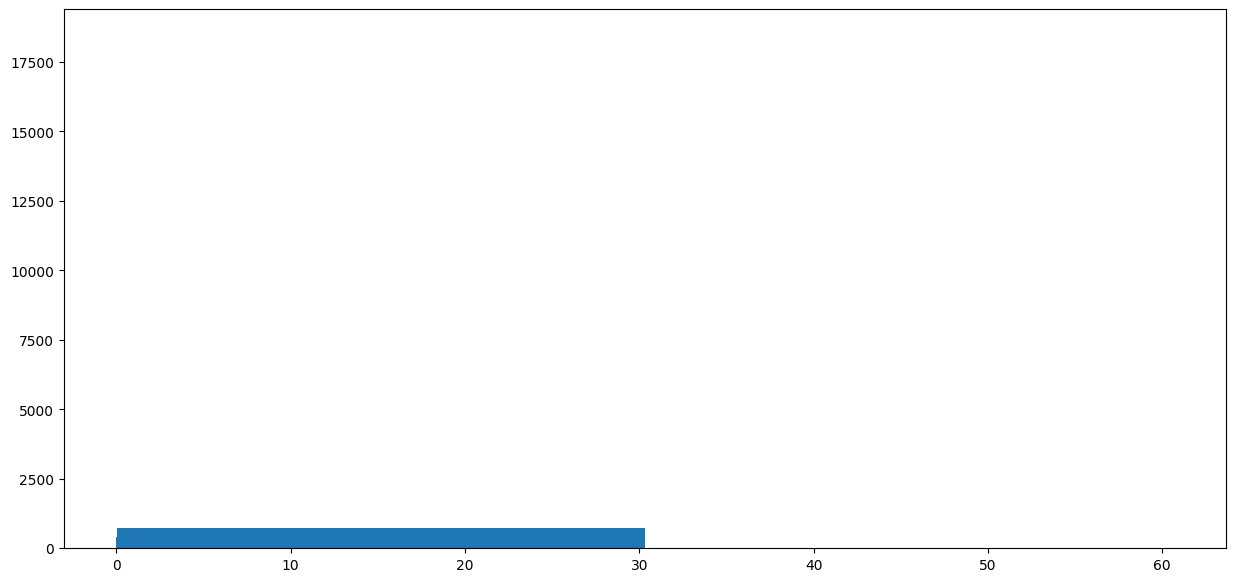

In [10]:
plot_histogram(joules_diff)

n_per_bin:  [1.0000e+00 1.1042e+04 8.5660e+03 8.0000e+00]
bins:  [6.13272625e-05 5.40483785e-04 1.01964031e-03 1.19014160e-03
 1.36064288e-03]


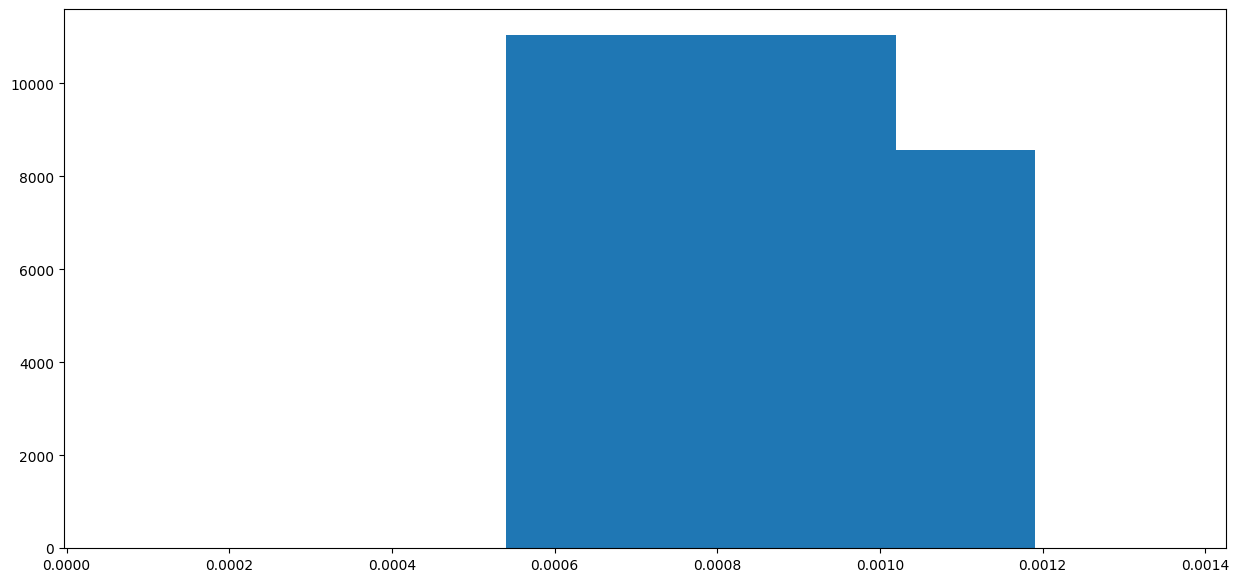

In [11]:
plot_histogram(timestamp_diff)

### Checking if negative eigenvalues still show up after several changes to log parsing.

--> Should see none

In [13]:
#cd ..

/home/tanneen/energy_project/full_logs


In [21]:
energy_eig_df = pd.read_csv('new_eigenval_dfs/energy_eig_0xd00_400k.csv', sep = ',')

In [24]:
energy_eig_df[(energy_eig_df['eig_0'] <= 0) | (energy_eig_df['eig_1'] <= 0) | (energy_eig_df['eig_2'] <= 0) |(energy_eig_df['eig_3'] <= 0) |(energy_eig_df['eig_4'] <= 0) |(energy_eig_df['eig_5'] <= 0) |(energy_eig_df['eig_6'] <= 0) |(energy_eig_df['eig_7'] <= 0) |(energy_eig_df['eig_8'] <= 0) |(energy_eig_df['eig_9'] <= 0)]

Empty DataFrame
Columns: [desc, joules_sum, eig_0, eig_1, eig_2, eig_3, eig_4, eig_5, eig_6, eig_7, eig_8, eig_9]
Index: []

### Checking joules_sum values across all running cores of an experiment.

#### --> Should see joules_sum of (core_0 + core_1) comparable to old summary data

#### --> So far, looks like current (core_0 + core_1) joules_sum is lower than that reported in summary data

In [27]:
itr = '300'
dvfs = '0xf00'
qps = '400'
rapl = '135'
run = '0'

In [28]:
energy_eig_df = pd.read_csv('new_eigenval_dfs/energy_eig_' + dvfs + '_' + qps + 'k.csv', sep = ',')
#energy_eig_df

In [29]:
summary_df = pd.read_csv('linux_mcd.csv', sep=' ')
#summary_df

In [31]:
t_joules = 0
for c in range(0, 16):
    desc = run + '_' + str(c) + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps + '000'
    joules_sum = energy_eig_df[energy_eig_df['desc'] == desc]['joules_sum']
    print('CORE ', c, joules_sum.values[0])
    if ((c == 0) | (c == 1)):
        t_joules += joules_sum.values[0]
print('core_0 + core_1 joules: ', t_joules)

CORE  0 628.7110233600033
CORE  1 627.2449646399982
CORE  2 628.7110233600033
CORE  3 627.2449646399982
CORE  4 628.7110233600033
CORE  5 627.2449646399982
CORE  6 628.7110233600033
CORE  7 627.2449646399982
CORE  8 628.7110233600033
CORE  9 627.2449646399982
CORE  10 628.7110233600033
CORE  11 627.2449646399982
CORE  12 628.7421690200026
CORE  13 627.2449646399982
CORE  14 628.7421690200026
CORE  15 627.2449646399982
core_0 + core_1 joules:  1255.9559880000015


In [33]:
summary = summary_df[(summary_df['i'] == 0) & (summary_df['itr'] == int(itr)) & (summary_df['dvfs'] == dvfs) & (summary_df['rapl'] == int(rapl)) & (np.abs(summary_df['QPS'] - int(qps+'000')) <= 1000)]
summary

sys  i  itr   dvfs  rapl       QPS  time    joule           ins  \
1484  linux  0  300  0xf00   135  399822.8  30.0  1899.51  262557341787   

               cyc  ...  c6            c7  read_5th  read_10th read_50th  \
1484  411122691640  ...   0  458747232668     108.8      131.1     249.2   

      read_90th  read_95th  read_99th      RDTSC_START        RDTSC_END  
1484      361.5      389.2      440.3  364039558410392  364126571955316  

[1 rows x 23 columns]

In [34]:
print('current core_0 + core_1 joules = ', t_joules)
print('summary core_0 + core_1 joules = ', summary['joule'].values[0])

current core_0 + core_1 joules =  1255.9559880000015
summary core_0 + core_1 joules =  1899.51


### Looking at all available energy numbers

In [35]:
#summary_df = pd.read_csv('linux_mcd.csv', sep=' ')
#summary_df[(summary_df['rapl'] == 135)  & (summary_df['i'] == 0)]

In [3]:
summary_df = pd.read_csv('mcd_combined.csv', sep=' ')
summary_df = summary_df[(summary_df['sys'] == 'linux_tuned') & (summary_df['rapl'] == 135) & (summary_df['i'] == 0)].copy()
summary_df

sys  i  itr    dvfs  rapl  read_5th  read_10th  read_50th  \
2073  linux_tuned  0   50   0xd00   135      60.9       63.5       86.5   
2093  linux_tuned  0   50   0xd00   135      69.8       76.4      106.6   
2096  linux_tuned  0   50   0xd00   135      82.4       93.3      159.3   
2099  linux_tuned  0  100   0xd00   135      67.1       74.9      117.1   
2102  linux_tuned  0  100   0xd00   135      81.1       90.7      136.4   
...           ... ..  ...     ...   ...       ...        ...        ...   
4591  linux_tuned  0  200  0x1500   135      62.3       73.5      159.0   
4594  linux_tuned  0  300  0x1500   135      65.4       77.9      206.3   
4597  linux_tuned  0  300  0x1500   135      76.4       94.1      218.5   
4600  linux_tuned  0  400  0x1500   135      75.9       96.2      269.2   
4603  linux_tuned  0  400  0x1500   135      89.1      111.9      277.9   

      read_90th  read_95th  ...  instructions        cycles    ref_cycles  \
2073      113.4      120.7  ...  1.025400e+11  2.063841e+11  4.604119e+11   
2093      157.3      188.9  ...  1.656852e+11  3.264325e+11  7.282110e+11   
2096      610.0     1154.6  ...  2.122615e+11  3.800900e+11  8.479005e+11   
2099      157.6      167.5  ...  9.596738e+10  1.882476e+11  4.201351e+11   
2102      186.4      207.1  ...  1.619789e+11  3.074678e+11  6.859082e+11   
...         ...        ...  ...           ...           ...           ...   
4591      243.2      257.5  ...  4.287341e+10  1.009820e+11  1.660464e+11   
4594      336.3      356.6  ...  2.610134e+10  6.919222e+10  1.210888e+11   
4597      338.4      357.3  ...  4.148048e+10  9.708454e+10  1.599017e+11   
4600      432.0      456.3  ...  2.513027e+10  6.568001e+10  1.148157e+11   
4603      431.8      455.6  ...  4.020456e+10  9.252286e+10  1.512654e+11   

         llc_miss         c1        c1e        c3   c6        c7  \
2073  251558200.0  3282844.0  1910656.0   41333.0  0.0  106404.0   
2093  676206273.0  3378200.0   404637.0    1384.0  0.0    4948.0   
2096  838639767.0  1568848.0    71782.0     316.0  0.0    3382.0   
2099  239626738.0  1101018.0  2484461.0  118089.0  0.0  298711.0   
2102  602785694.0  2178213.0  1052913.0   16329.0  0.0   36594.0   
...           ...        ...        ...       ...  ...       ...   
4591  101618246.0    77305.0  1220504.0  420750.0  0.0  510024.0   
4594   65019571.0    36275.0   711887.0  363992.0  0.0  542538.0   
4597   97769821.0    56138.0   850995.0  361710.0  0.0  579193.0   
4600   62246340.0    29098.0   547063.0  297758.0  0.0  564327.0   
4603   96910380.0    46218.0   679658.0  332095.0  0.0  586894.0   

      num_interrupts  
2073         5217306  
2093         6045976  
2096         6169252  
2099         3017019  
2102         3115674  
...              ...  
4591         1437720  
4594          937326  
4597         1022205  
4600          731599  
4603          766951  

[475 rows x 29 columns]

### Looking at joules_sum (and/or instructions, cycles, ref_cycles, llc_misses) values
#### --> before and after overflow identification 
#### --> across all logs

In [4]:
def compare_joules_sum(df_dir, ignore_overflow):
    for file in os.listdir(df_dir):
        print(file)

        # df holding per-core joules_sum for all attempted itr-delay values
        df_energy_eig = pd.read_csv(df_dir+file, sep = ',')

        itrs = set(list(df_energy_eig['desc'].apply(lambda x: int(x.split('_')[2]))))
        # constant qps and dvfs per energy_eig file
        if ignore_overflow:
            qps = file.split('_')[5].split('.')[0].split('k')[0]
            dvfs = file.split('_')[4]
        else:
            qps = file.split('_')[3].split('.')[0].split('k')[0]
            dvfs = file.split('_')[2]

        for itr in itrs:
            t_joules = 0
            c0_c1_joules = 0
            summary_joules = 0

            for c in range(0, 16):
                desc = str(i) + '_' + str(c) + '_' + str(itr) + '_' + dvfs + '_' + str(rapl) + '_' + qps + '000'
                #print(desc)
                c_joules_sum = df_energy_eig[df_energy_eig['desc'] == desc]['joules_sum']
                c_joules_sum = c_joules_sum.values[0]
                #print('CORE ', c, c_joules_sum)
                t_joules += c_joules_sum
                if ((c == 0) | (c == 1)):
                    c0_c1_joules += c_joules_sum

            summary_joules = summary_df[(summary_df['itr'] == itr) & (summary_df['dvfs'] == dvfs) \
                                & (summary_df['i'] == 0) & (summary_df['target_QPS'] == int(qps+'000'))]['joules']
            if (len(summary_joules) == 0):
                summary_joules = 'N/A'
            else:
                summary_joules = summary_joules.values[0]
            key = str(i) + '_' + dvfs + '_' + str(itr) + '_' + qps + 'k'
            dict_energy[key] = {'total': t_joules, 'c0+c1': c0_c1_joules, 'summary':summary_joules}
    return dict_energy

In [5]:
i = 0
rapl = 135
dict_energy = {}

df_dir = 'new_eigenval_dfs/'
df_dir_ignore_overflow = 'ignore_overflow_new_eigenval_dfs/'
dict_energy = compare_joules_sum(df_dir, ignore_overflow = False)
dict_energy_ignore_overflow = compare_joules_sum(df_dir_ignore_overflow, ignore_overflow = True)


df_energy = pd.DataFrame.from_dict(dict_energy, orient='index')
df_energy_ignore_overflow = pd.DataFrame.from_dict(dict_energy_ignore_overflow, orient='index')
df_energy_ignore_overflow = df_energy_ignore_overflow.drop(['summary'], axis=1)
df_energy_ignore_overflow.columns = [f'{c}_ignore_overflow' for c in df_energy_ignore_overflow.columns]

#print(df_energy)
#print(df_energy_ignore_overflow)

energy_eig_0xd00_600k.csv
energy_eig_0xf00_400k.csv
energy_eig_0x1300_200k.csv
energy_eig_0x1100_600k.csv
energy_eig_0x1100_200k.csv
energy_eig_0xf00_200k.csv
energy_eig_0xd00_400k.csv
energy_eig_0x1300_600k.csv
energy_eig_0x1100_400k.csv
energy_eig_0xd00_200k.csv
energy_eig_0xf00_600k.csv
ignore_overflow_energy_eig_0x1100_200k.csv
ignore_overflow_energy_eig_0x1100_600k.csv
ignore_overflow_energy_eig_0x1100_400k.csv
ignore_overflow_energy_eig_0xf00_600k.csv
ignore_overflow_energy_eig_0xf00_200k.csv
ignore_overflow_energy_eig_0x1300_200k.csv
ignore_overflow_energy_eig_0xd00_600k.csv
ignore_overflow_energy_eig_0xd00_200k.csv
ignore_overflow_energy_eig_0xf00_400k.csv
ignore_overflow_energy_eig_0x1300_600k.csv
ignore_overflow_energy_eig_0xd00_400k.csv


### Observing no difference in joules_sum values before and after overflow handling...
#### --> Does this make sense?

In [20]:
df = pd.concat([df_energy, df_energy_ignore_overflow], axis=1)
df_c0_c1 = df[['c0+c1', 'c0+c1_ignore_overflow']]
df_total = df[['total', 'total_ignore_overflow']]
#df_total_diffs = df_total.diff(axis=1)
#df_total_diffs[df_total_diffs['c0+c1_ignore_overflow'] > 0]

In [25]:
#df_c0_c1
#df_total_diffs[df_total_diffs['total_ignore_overflow'] > 0]
list(df_total.index)

['0_0xd00_350_600k',
 '0_0xd00_2_600k',
 '0_0xd00_100_600k',
 '0_0xd00_200_600k',
 '0_0xd00_40_600k',
 '0_0xd00_10_600k',
 '0_0xd00_300_600k',
 '0_0xd00_400_600k',
 '0_0xd00_50_600k',
 '0_0xd00_20_600k',
 '0_0xd00_250_600k',
 '0_0xd00_30_600k',
 '0_0xf00_2_400k',
 '0_0xf00_100_400k',
 '0_0xf00_200_400k',
 '0_0xf00_40_400k',
 '0_0xf00_10_400k',
 '0_0xf00_300_400k',
 '0_0xf00_400_400k',
 '0_0xf00_50_400k',
 '0_0xf00_20_400k',
 '0_0xf00_30_400k',
 '0_0xf00_250_400k',
 '0_0xf00_350_400k',
 '0_0x1300_2_200k',
 '0_0x1300_100_200k',
 '0_0x1300_40_200k',
 '0_0x1300_200_200k',
 '0_0x1300_10_200k',
 '0_0x1300_300_200k',
 '0_0x1300_400_200k',
 '0_0x1300_50_200k',
 '0_0x1300_20_200k',
 '0_0x1300_30_200k',
 '0_0x1300_250_200k',
 '0_0x1300_350_200k',
 '0_0x1100_2_600k',
 '0_0x1100_100_600k',
 '0_0x1100_200_600k',
 '0_0x1100_40_600k',
 '0_0x1100_10_600k',
 '0_0x1100_300_600k',
 '0_0x1100_400_600k',
 '0_0x1100_50_600k',
 '0_0x1100_20_600k',
 '0_0x1100_30_600k',
 '0_0x1100_250_600k',
 '0_0x1100_350_600

## TODO
### Histogram of (joules_sum_total / joules_sum_c0_c1) - 1) ratios across logs

In [6]:
# TODO

TODO:

- run logs for 400k, 600k and test generalization of these models
- might need some additional information about time between interrupts (additional column)

Status:

- there's signal in the spectrum (distribution of eigenvalues) about the true latency
- question: what's the interpretation of this? do we need one (it would be nice but not necessary for predictions)?

In [2]:
df = pd.read_csv('lat_eig_200k.csv')
df.head()

desc    avg    std   min   5th   10th   50th   90th  \
0  0_100_0x1d00_135_200000  100.3   31.5  37.4  51.3   57.3  100.6  141.1   
1   0_10_0x1d00_135_200000   49.1    4.6  34.0  42.2   43.3   48.5   55.5   
2  0_350_0x1d00_135_200000  244.2  102.6  41.1  82.7  103.7  245.5  381.3   
3   0_40_0x1d00_135_200000   60.9   12.9  34.0  43.8   45.9   58.7   79.1   
4  0_350_0x1d00_135_200000  244.2  102.6  41.1  82.7  103.7  245.5  381.3   

    95th   99th  ...     eig_4     eig_5     eig_6     eig_7     eig_8  \
0  151.5  171.5  ...  0.440060  0.000859  0.000327  0.000053  0.000017   
1   58.5   64.5  ...  0.162246  0.003525  0.000319  0.000128  0.000045   
2  400.0  437.7  ...  0.424921  0.066377  0.001418  0.000451  0.000151   
3   83.4   88.1  ...  0.505817  0.004241  0.000343  0.000143  0.000019   
4  400.0  437.7  ...  0.411281  0.021113  0.003975  0.000559  0.000281   

      eig_9        eig_10        eig_11        eig_12        eig_13  
0  0.000011  7.398808e-06  2.850891e-06  1.803686e-07  9.683146e-08  
1  0.000021  3.140831e-06  1.732030e-07  3.880479e-08  1.932744e-13  
2  0.000032  1.899372e-05  2.834952e-07  1.581454e-06  1.421811e-06  
3  0.000007  9.731156e-07  4.427437e-07  2.197987e-07  1.825507e-09  
4  0.000061  1.589944e-05  6.504408e-06  6.299850e-07  1.045465e-06  

[5 rows x 24 columns]

In [3]:
df['itr'] = df['desc'].apply(lambda x: int(x.split('_')[1]))
df['dvfs'] = df['desc'].apply(lambda x: int(x.split('_')[2], base=16))

In [4]:
df.head()

desc    avg    std   min   5th   10th   50th   90th  \
0  0_100_0x1d00_135_200000  100.3   31.5  37.4  51.3   57.3  100.6  141.1   
1   0_10_0x1d00_135_200000   49.1    4.6  34.0  42.2   43.3   48.5   55.5   
2  0_350_0x1d00_135_200000  244.2  102.6  41.1  82.7  103.7  245.5  381.3   
3   0_40_0x1d00_135_200000   60.9   12.9  34.0  43.8   45.9   58.7   79.1   
4  0_350_0x1d00_135_200000  244.2  102.6  41.1  82.7  103.7  245.5  381.3   

    95th   99th  ...     eig_6     eig_7     eig_8     eig_9        eig_10  \
0  151.5  171.5  ...  0.000327  0.000053  0.000017  0.000011  7.398808e-06   
1   58.5   64.5  ...  0.000319  0.000128  0.000045  0.000021  3.140831e-06   
2  400.0  437.7  ...  0.001418  0.000451  0.000151  0.000032  1.899372e-05   
3   83.4   88.1  ...  0.000343  0.000143  0.000019  0.000007  9.731156e-07   
4  400.0  437.7  ...  0.003975  0.000559  0.000281  0.000061  1.589944e-05   

         eig_11        eig_12        eig_13  itr  dvfs  
0  2.850891e-06  1.803686e-07  9.683146e-08  100  7424  
1  1.732030e-07  3.880479e-08  1.932744e-13   10  7424  
2  2.834952e-07  1.581454e-06  1.421811e-06  350  7424  
3  4.427437e-07  2.197987e-07  1.825507e-09   40  7424  
4  6.504408e-06  6.299850e-07  1.045465e-06  350  7424  

[5 rows x 26 columns]

In [5]:
eig_cols = [c for c in df if c.find('eig')>-1]
eig_cols

['eig_0',
 'eig_1',
 'eig_2',
 'eig_3',
 'eig_4',
 'eig_5',
 'eig_6',
 'eig_7',
 'eig_8',
 'eig_9',
 'eig_10',
 'eig_11',
 'eig_12',
 'eig_13']

In [6]:
#should add to n where correlation matrix is n x n since Tr(C) = n
df[eig_cols].sum(axis=1).unique()

array([14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
       14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
       14., 14., 14.])

In [7]:
#correlation matrix C = X^T X i.e. positive definite -> eigenvalues should be positive
(df[eig_cols] <= 0).sum().sum()

0

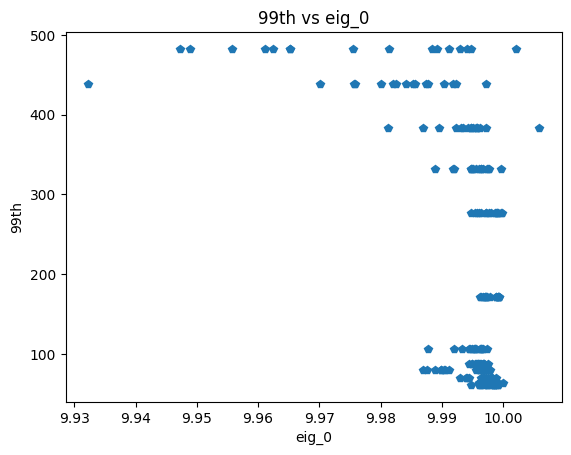

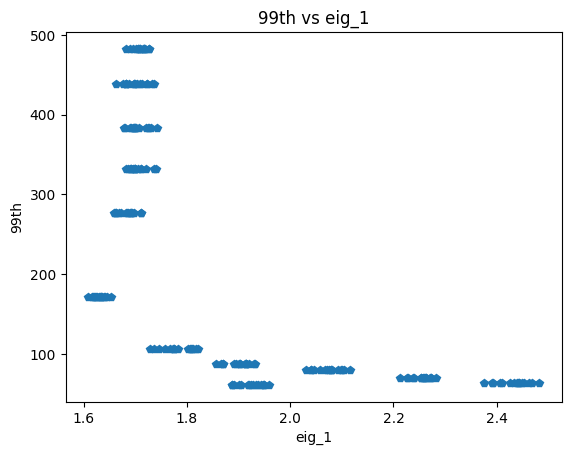

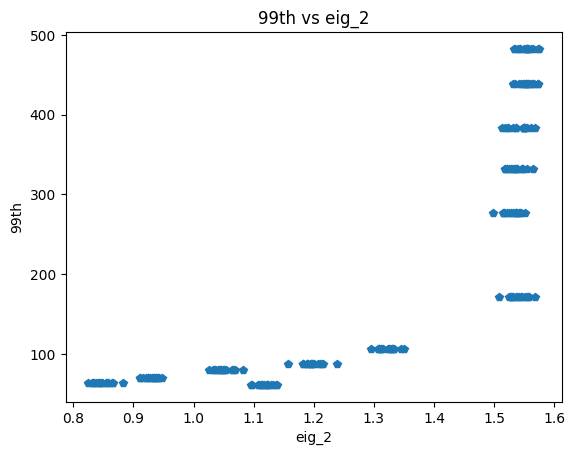

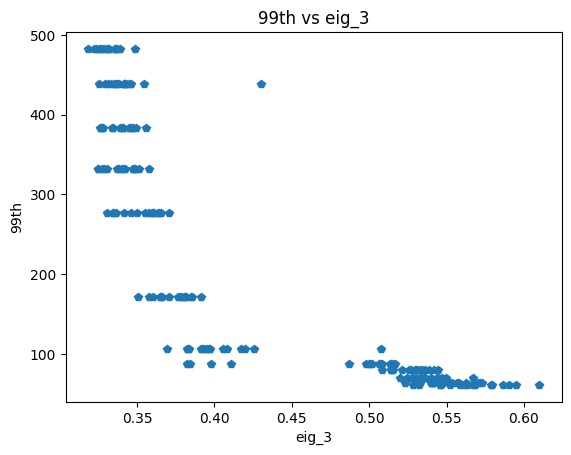

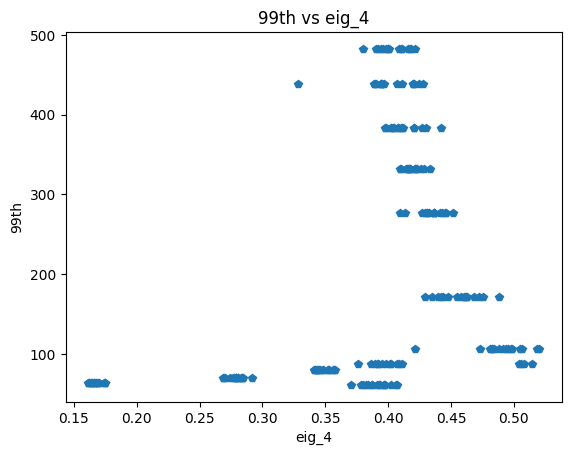

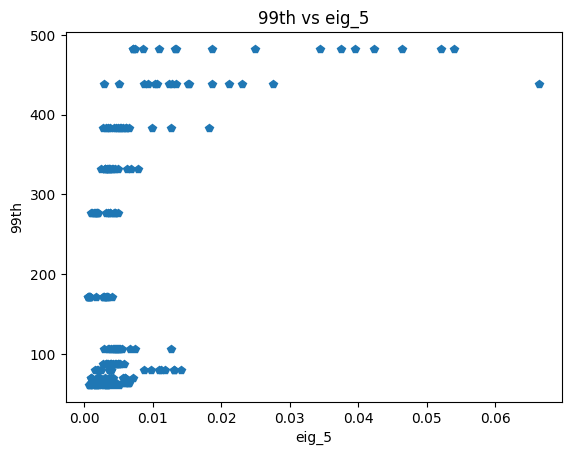

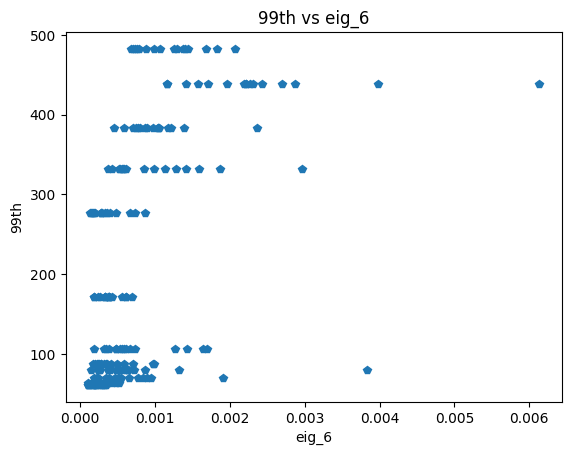

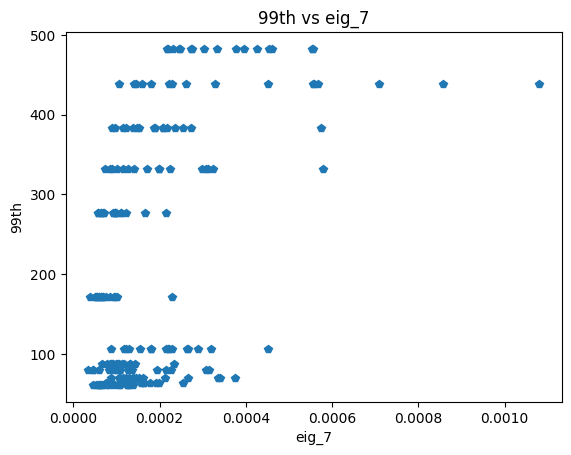

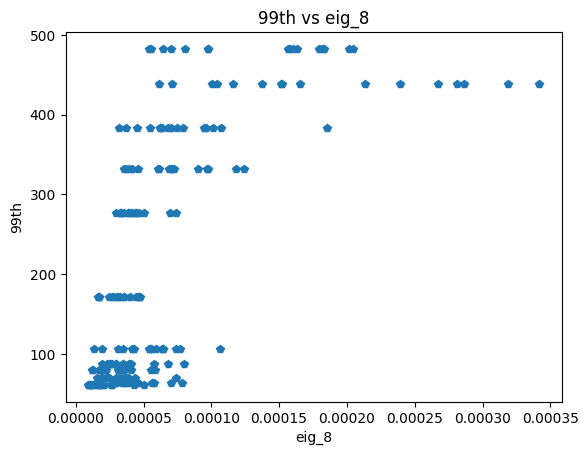

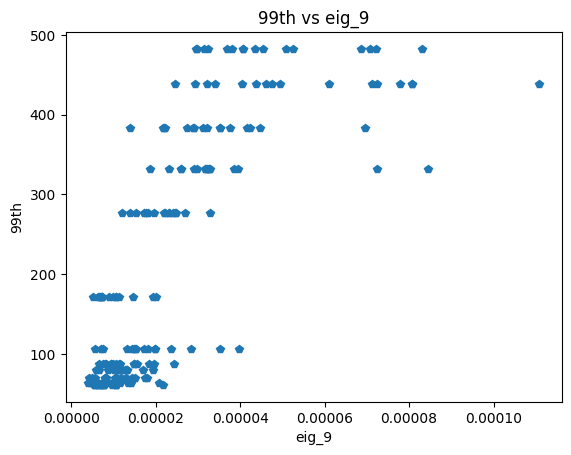

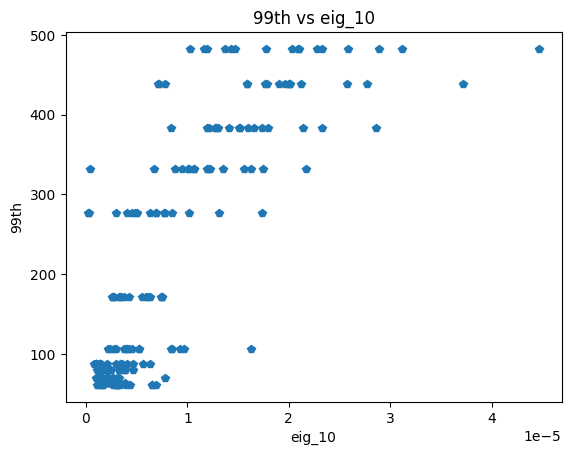

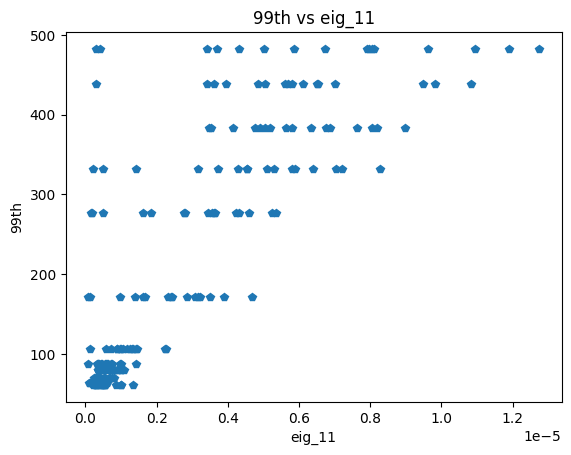

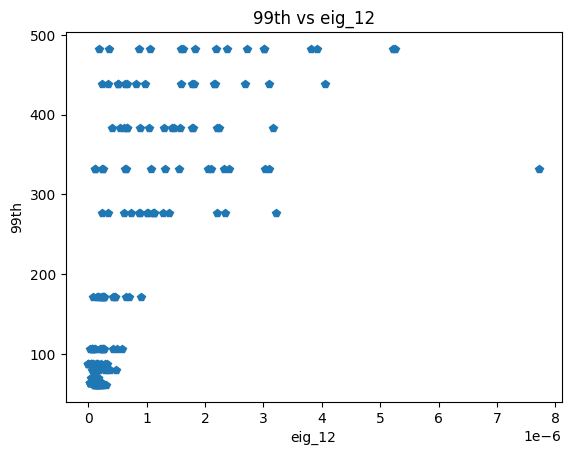

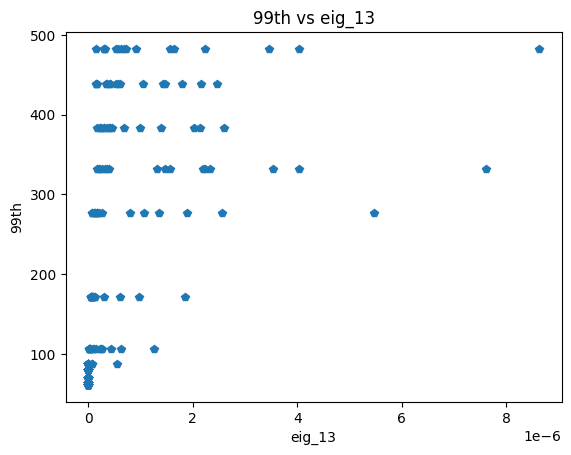

In [8]:
#plot kth eigenvalue vs latency
lat_col = '99th'
for c in eig_cols:
    plt.figure()
    plt.plot(df[c], df[lat_col], 'p')
    plt.xlabel(c)
    plt.ylabel(lat_col)
    plt.title(f'{lat_col} vs {c}')

In [9]:
n_iter = 10

scale = True
ratios = True
log = False

scorer = r2_score

def run_exp(model,
            df,
            scale=True, 
            ratios=True, 
            log=False, 
            n_iter=10, 
            scorer=r2_score,
            plot=False):

    score_list, model_list = [], []

    for i in range(n_iter):
        #split into train and test sets
        df_train, df_test = train_test_split(df, train_size=0.7)
        
        if i==0: print(df_train.shape, df_test.shape)

        #define features to be eigenvalues
        df_train_feats = df_train[eig_cols].copy()
        df_test_feats = df_test[eig_cols].copy()
    
        #define latency column to be target
        df_train_y = df_train[lat_col].copy()
        df_test_y = df_test[lat_col].copy()
    
        #
        if ratios: #features are scaled by highest eigenvalue (assumed to be eig_0 although should check this)
            for c in eig_cols:
                df_train_feats[c] = df_train_feats[c] / df_train_feats['eig_0']
                df_test_feats[c] = df_test_feats[c] / df_test_feats['eig_0']

            df_train_feats.drop('eig_0', axis=1, inplace=True)
            df_test_feats.drop('eig_0', axis=1, inplace=True)

        feat_col_names = df_train_feats.columns

        if log: #take logs of features to suppress scales
            df_train_feats = df_train_feats.apply(lambda x: np.log(x), axis=1)
            df_test_feats = df_test_feats.apply(lambda x: np.log(x), axis=1)

        if scale: #standard normalization for linear models
            scaler = StandardScaler(with_mean=True, with_std=True)
            df_train_feats = scaler.fit_transform(df_train_feats)
            df_test_feats = scaler.transform(df_test_feats)

        model.fit(df_train_feats, df_train_y)

        pred_train = model.predict(df_train_feats)
        pred_test = model.predict(df_test_feats)

        labels_train = df_train_y
        labels_test = df_test_y
        
        if plot:
            plt.figure(figsize=(5,3))
            plt.plot(labels_train, pred_train, 'p', label='train')
            plt.plot(labels_test, pred_test, 'p', label='test')
            plt.plot(labels_train, labels_train, '-')
            plt.xlim((0, 500))
            plt.ylim((0, 500))
            plt.legend()
            plt.grid()
            plt.xlabel('labels')
            plt.ylabel('preds')

        train_score = scorer(pred_train, labels_train)
        test_score = scorer(pred_test, labels_test)

        score_list.append((train_score, test_score))
    
    return score_list, model, feat_col_names #this is the last trained model but ok for now

In [10]:
for model in LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor():

    score_list, model, feat_col_names = run_exp(model,
                                                df,
                                                scale=True, 
                                                ratios=True, 
                                                log=False, 
                                                n_iter=10, 
                                                scorer=r2_score,
                                                plot=False) #change plot->True to see plots

    score_mean, score_std = np.mean([i[1] for i in score_list]), np.std([i[1] for i in score_list]) #no log
    print(f'model={model} {score_mean - score_std:.3f}--{score_mean:.3f}--{score_mean + score_std:.3f}\n')

(134, 26) (58, 26)
model=LinearRegression() 0.928--0.946--0.964

(134, 26) (58, 26)
model=Lasso() 0.931--0.942--0.953

(134, 26) (58, 26)
model=Ridge() 0.933--0.946--0.959

(134, 26) (58, 26)
model=DecisionTreeRegressor() 0.920--0.945--0.970

(134, 26) (58, 26)
model=RandomForestRegressor() 0.933--0.958--0.984



In [11]:
sorted(zip(feat_col_names, 100*model.feature_importances_), 
       key=operator.itemgetter(1), 
       reverse=True)

[('eig_3', 77.79587483419826),
 ('eig_9', 6.74858402237067),
 ('eig_5', 6.052202486204653),
 ('eig_1', 2.9251420348521737),
 ('eig_2', 2.4674038625790593),
 ('eig_10', 1.0059474935080692),
 ('eig_11', 0.9291812611341125),
 ('eig_6', 0.5594283261370744),
 ('eig_13', 0.3952953697155486),
 ('eig_7', 0.3602126327875633),
 ('eig_8', 0.2994966579683746),
 ('eig_4', 0.2990985969858196),
 ('eig_12', 0.16213242155860708)]

### Useful functions


In [12]:
def read_df(fname):
    df = pd.read_csv(fname)
    
    df['itr'] = df['desc'].apply(lambda x: int(x.split('_')[1]))
    df['dvfs'] = df['desc'].apply(lambda x: int(x.split('_')[2], base=16))
    
    eig_cols = [c for c in df if c.find('eig')>-1]

    assert(np.allclose(df[eig_cols].sum(axis=1), len(eig_cols)))
    
    assert((df[eig_cols] <= 0).sum().sum()==0)
    
    return df, eig_cols

def plot_scatter(df, lat_col = '99th'):
    #plot kth eigenvalue vs latency
    for c in eig_cols:
        plt.figure(figsize=(5,3))
        plt.plot(df[c], df[lat_col], 'p')
        plt.xlabel(c)
        plt.ylabel(lat_col)
        plt.title(f'{lat_col} vs {c}')
        
def train(model,
          lat_col,
          df_train,
          df_test,
          scale=True, 
          ratios=True, 
          log=False, 
          scorer=r2_score,
          plot=False):
    '''
    Very similar to run_exp but df_train
    and df_test are passed explicitly for one iter
    
    Useful for training on 200k and testing on 400k/600k
    '''
    
    #define features to be eigenvalues
    df_train_feats = df_train[eig_cols].copy()
    df_test_feats = df_test[eig_cols].copy()

    #define latency column to be target
    df_train_y = df_train[lat_col].copy()
    df_test_y = df_test[lat_col].copy()

    if ratios: #features are scaled by highest eigenvalue (assumed to be eig_0 although should check this)
        for c in eig_cols:
            df_train_feats[c] = df_train_feats[c] / df_train_feats['eig_0']
            df_test_feats[c] = df_test_feats[c] / df_test_feats['eig_0']

        df_train_feats.drop('eig_0', axis=1, inplace=True)
        df_test_feats.drop('eig_0', axis=1, inplace=True)

    feat_col_names = df_train_feats.columns

    if log: #take logs of features to suppress scales
        df_train_feats = df_train_feats.apply(lambda x: np.log(x), axis=1)
        df_test_feats = df_test_feats.apply(lambda x: np.log(x), axis=1)

    if scale: #standard normalization for linear models
        scaler = StandardScaler(with_mean=True, with_std=True)
        df_train_feats = scaler.fit_transform(df_train_feats)
        df_test_feats = scaler.transform(df_test_feats)

    model.fit(df_train_feats, df_train_y)

    pred_train = model.predict(df_train_feats)
    pred_test = model.predict(df_test_feats)

    labels_train = df_train_y
    labels_test = df_test_y

    if plot:
        plt.figure(figsize=(5,3))
        plt.plot(labels_train, pred_train, 'p', label='train')
        plt.plot(labels_test, pred_test, 'p', label='test')
        plt.plot(labels_train, labels_train, '-')
        plt.xlim((0, 500))
        plt.ylim((0, 500))
        plt.legend()
        plt.grid()
        plt.xlabel('labels')
        plt.ylabel('preds')

    train_score = scorer(pred_train, labels_train)
    test_score = scorer(pred_test, labels_test)
    
    return model, train_score, test_score     

In [13]:
#read data
df_200, eig_cols = read_df('lat_eig_200k.csv')
df_400, _ = read_df('lat_eig_400k.csv')
df_600, _ = read_df('lat_eig_600k.csv')

In [14]:
df_200.shape, df_400.shape, df_600.shape #should have same number of columns

((192, 26), (192, 26), (192, 26))

In [59]:
#plot_scatter(df_400)

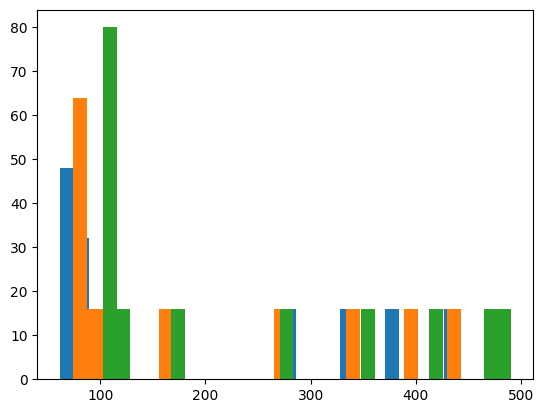

In [15]:
#check distributions of latency - mainly to ensure they are increasing
_ = plt.hist(df_200['99th'], bins=30)
_ = plt.hist(df_400['99th'], bins=30)
_ = plt.hist(df_600['99th'], bins=30)

train score = 0.996 test score = 0.030


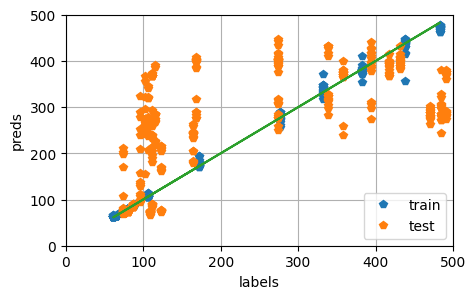

In [16]:
'''
Experiment 1:

Train on 200k and test on 400k/600k

The model doesn't generalize i.e. while train errors are low,
test errors are very high (R^2 ~ 0)

There are two obvious reasons for this:

a. during training, the model never had to learn patterns that help it predict QPS since QPS was uniform across
the training set. Training on a random split of the combined 200k/400k/600k should indicate whether this is true
(see below)

b. There's no information in the eigenvalue spectrum about the QPS i.e. the eigenvalue spectra don't change
as QPS changes (everything else being fixed). To be clear, "fixed" here doesn't mean constant - everything is a 
statistical quantity i.e. a random variable.
'''

lat_col = '99th'

scale = True
ratios = True
log = False

scorer = r2_score

model = RandomForestRegressor()

model, train_score, test_score = train(model,
                                       lat_col,
                                       df_200, #train = 200k
                                       pd.concat([df_400, df_600], axis=0), #test = Union(400k, 600k)
                                       scale=True, 
                                       ratios=True, 
                                       log=False, 
                                       scorer=r2_score,
                                       plot=True)      
print(f'train score = {train_score:.3f} test score = {test_score:.3f}')

In [17]:
'''
Experiment 2:

Run a separate train/test experiment on each QPS (using run_exp defined above)

Results: all the models are predictive (low errors, R^2 ~ 1)

This indicates that the eigenvalue spectrum does have useful information to predict latency
across different QPS values
'''

for df in df_200, df_400, df_600:
    print('------------------------')
    for model in LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor():

        score_list, model, feat_col_names = run_exp(model,
                                                    df_600,
                                                    scale=True, 
                                                    ratios=True, 
                                                    log=False, 
                                                    n_iter=10, 
                                                    scorer=r2_score,
                                                    plot=False) #change plot->True to see plots

        score_mean, score_std = np.mean([i[1] for i in score_list]), np.std([i[1] for i in score_list]) #no log
        print(f'model={model} {score_mean - score_std:.3f}--{score_mean:.3f}--{score_mean + score_std:.3f}\n')

------------------------
(134, 26) (58, 26)
model=LinearRegression() 0.801--0.846--0.891

(134, 26) (58, 26)
model=Lasso() 0.772--0.824--0.877

(134, 26) (58, 26)
model=Ridge() 0.794--0.844--0.893

(134, 26) (58, 26)
model=DecisionTreeRegressor() 0.863--0.921--0.979

(134, 26) (58, 26)
model=RandomForestRegressor() 0.911--0.953--0.994

------------------------
(134, 26) (58, 26)
model=LinearRegression() 0.758--0.830--0.902

(134, 26) (58, 26)
model=Lasso() 0.817--0.856--0.894

(134, 26) (58, 26)
model=Ridge() 0.805--0.848--0.891

(134, 26) (58, 26)
model=DecisionTreeRegressor() 0.869--0.924--0.979

(134, 26) (58, 26)
model=RandomForestRegressor() 0.876--0.929--0.982

------------------------
(134, 26) (58, 26)
model=LinearRegression() 0.733--0.811--0.888

(134, 26) (58, 26)
model=Lasso() 0.787--0.830--0.872

(134, 26) (58, 26)
model=Ridge() 0.752--0.825--0.898

(134, 26) (58, 26)
model=DecisionTreeRegressor() 0.854--0.914--0.974

(134, 26) (58, 26)
model=RandomForestRegressor() 0.956--

In [18]:
'''
Experiment 3:

Look at spectra for same itr combination across different QPS values

Q: are the spectra different? (see cell below)
'''

df_600.groupby('desc').count() #16 cores per experiment

avg  std  min  5th  10th  50th  90th  95th  99th  \
desc                                                                        
0_100_0x1d00_135_600000   16   16   16   16    16    16    16    16    16   
0_10_0x1d00_135_600000    16   16   16   16    16    16    16    16    16   
0_200_0x1d00_135_600000   16   16   16   16    16    16    16    16    16   
0_20_0x1d00_135_600000    16   16   16   16    16    16    16    16    16   
0_250_0x1d00_135_600000   16   16   16   16    16    16    16    16    16   
0_2_0x1d00_135_600000     16   16   16   16    16    16    16    16    16   
0_300_0x1d00_135_600000   16   16   16   16    16    16    16    16    16   
0_30_0x1d00_135_600000    16   16   16   16    16    16    16    16    16   
0_350_0x1d00_135_600000   16   16   16   16    16    16    16    16    16   
0_400_0x1d00_135_600000   16   16   16   16    16    16    16    16    16   
0_40_0x1d00_135_600000    16   16   16   16    16    16    16    16    16   
0_50_0x1d00_135_600000    16   16   16   16    16    16    16    16    16   

                         eig_0  ...  eig_6  eig_7  eig_8  eig_9  eig_10  \
desc                            ...                                       
0_100_0x1d00_135_600000     16  ...     16     16     16     16      16   
0_10_0x1d00_135_600000      16  ...     16     16     16     16      16   
0_200_0x1d00_135_600000     16  ...     16     16     16     16      16   
0_20_0x1d00_135_600000      16  ...     16     16     16     16      16   
0_250_0x1d00_135_600000     16  ...     16     16     16     16      16   
0_2_0x1d00_135_600000       16  ...     16     16     16     16      16   
0_300_0x1d00_135_600000     16  ...     16     16     16     16      16   
0_30_0x1d00_135_600000      16  ...     16     16     16     16      16   
0_350_0x1d00_135_600000     16  ...     16     16     16     16      16   
0_400_0x1d00_135_600000     16  ...     16     16     16     16      16   
0_40_0x1d00_135_600000      16  ...     16     16     16     16      16   
0_50_0x1d00_135_600000      16  ...     16     16     16     16      16   

                         eig_11  eig_12  eig_13  itr  dvfs  
desc                                                        
0_100_0x1d00_135_600000      16      16      16   16    16  
0_10_0x1d00_135_600000       16      16      16   16    16  
0_200_0x1d00_135_600000      16      16      16   16    16  
0_20_0x1d00_135_600000       16      16      16   16    16  
0_250_0x1d00_135_600000      16      16      16   16    16  
0_2_0x1d00_135_600000        16      16      16   16    16  
0_300_0x1d00_135_600000      16      16      16   16    16  
0_30_0x1d00_135_600000       16      16      16   16    16  
0_350_0x1d00_135_600000      16      16      16   16    16  
0_400_0x1d00_135_600000      16      16      16   16    16  
0_40_0x1d00_135_600000       16      16      16   16    16  
0_50_0x1d00_135_600000       16      16      16   16    16  

[12 rows x 25 columns]

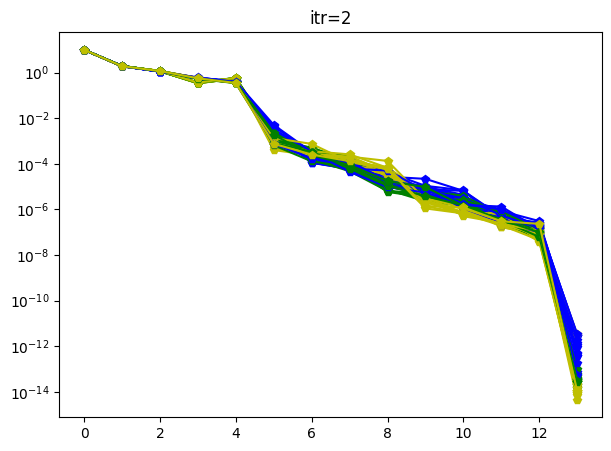

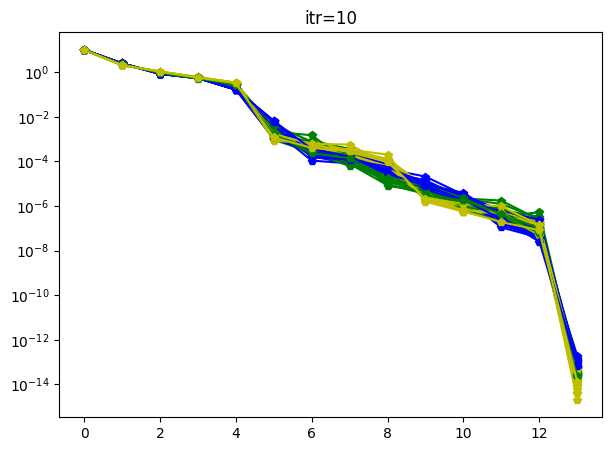

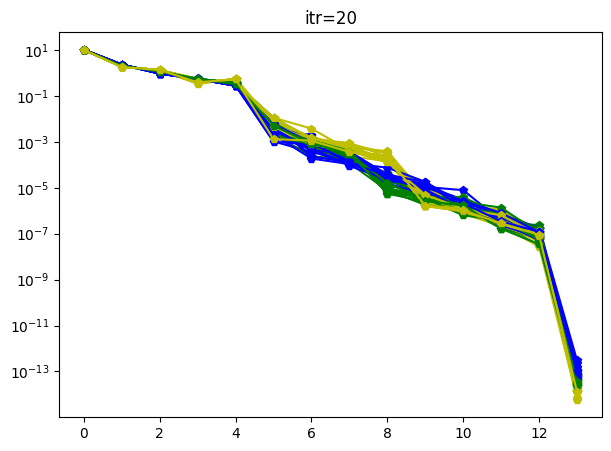

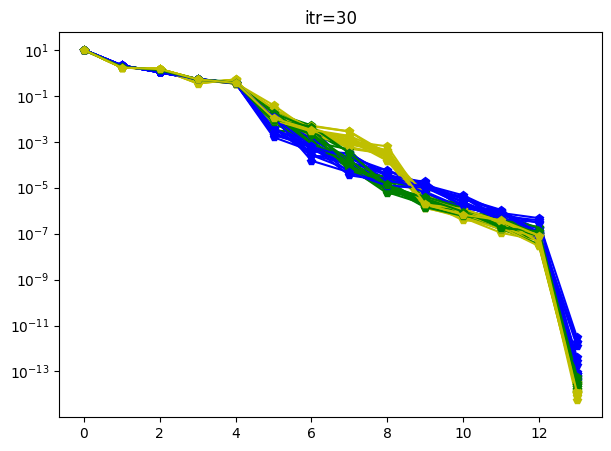

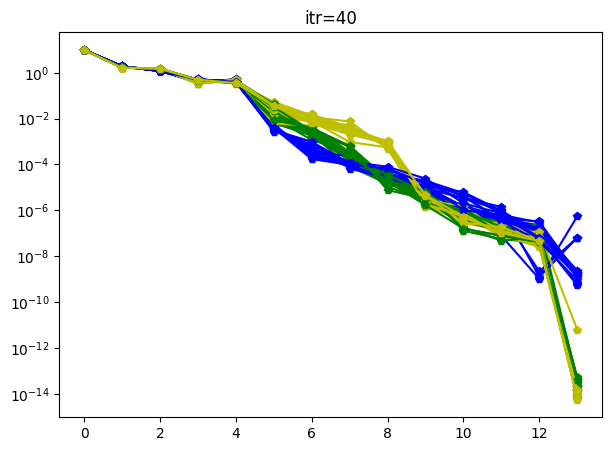

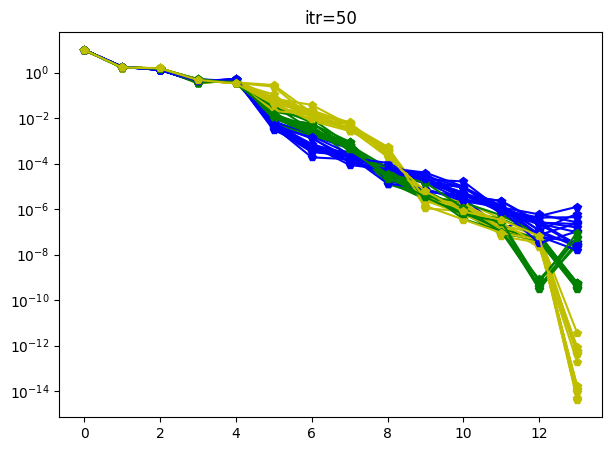

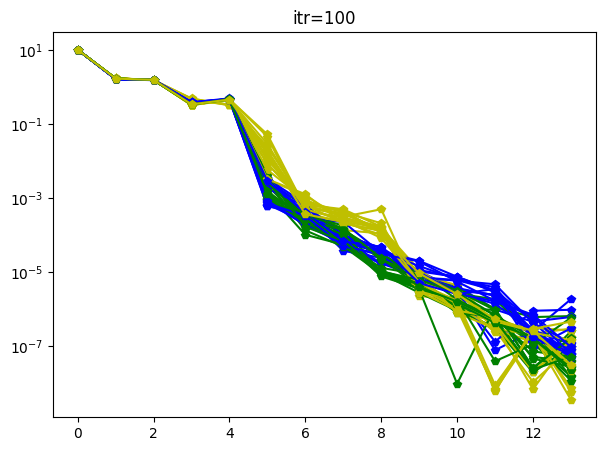

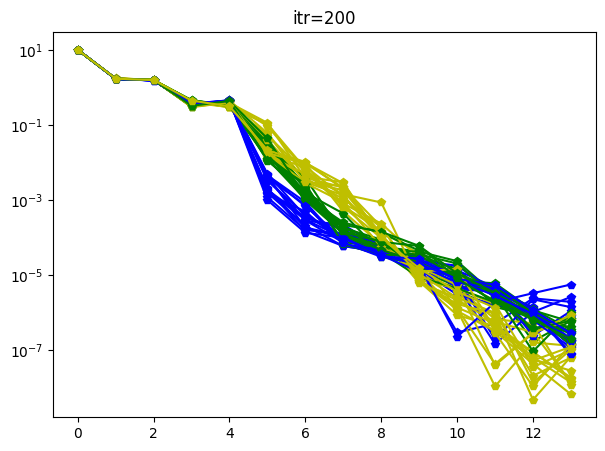

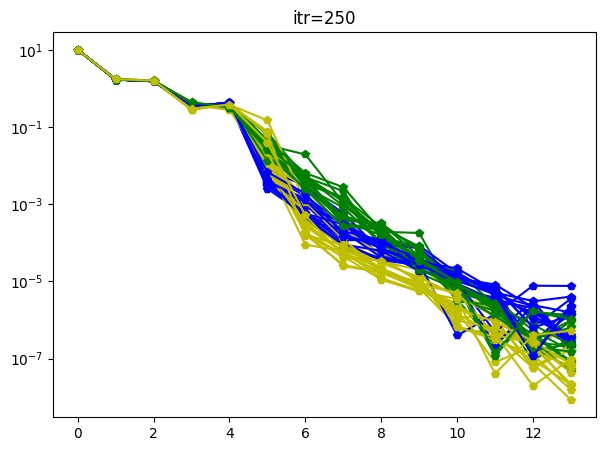

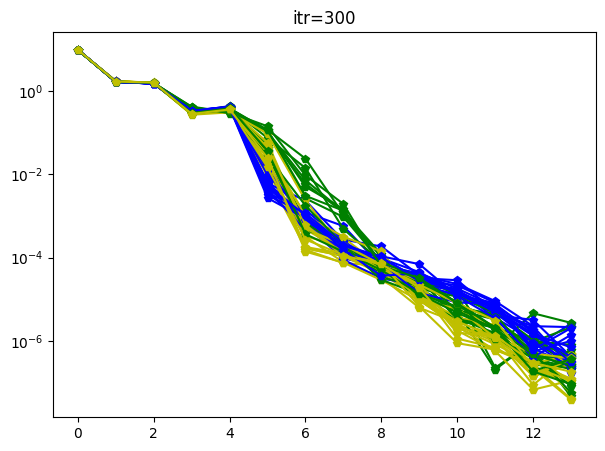

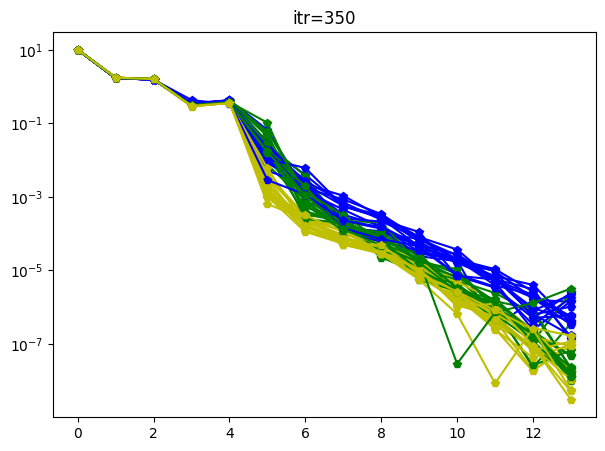

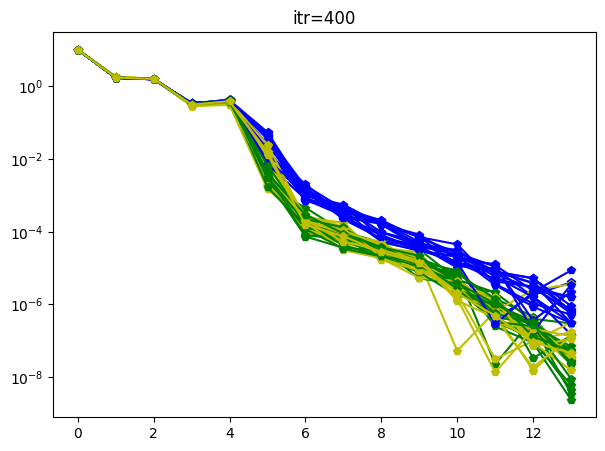

In [19]:
'''
Experiment 3 (same as above):

- There's a lot of noise in the eigenvalues across cores BUT
there are some clear patterns of distribution in the intermediate
and low eigenvalues

- This suggests that training of some QPS values will help
'''

for itr in np.sort(df_200.itr.unique()):

    key=f'0_{itr}_0x1d00_135'

    plt.figure(figsize=(7,5))
    plt.title(f'itr={itr}')
    for i in range(16):
        plt.plot(df_200[df_200.desc==f'{key}_200000'].iloc[i][eig_cols].tolist(), 'p-', color='b', label='200k')
        plt.plot(df_400[df_400.desc==f'{key}_400000'].iloc[i][eig_cols].tolist(), 'p-', color='g', label='400k')
        plt.plot(df_600[df_600.desc==f'{key}_600000'].iloc[i][eig_cols].tolist(), 'p-', color='y', label='600k')
    plt.yscale('log')

(403, 26) (173, 26)
model=RandomForestRegressor() 0.913--0.932--0.952



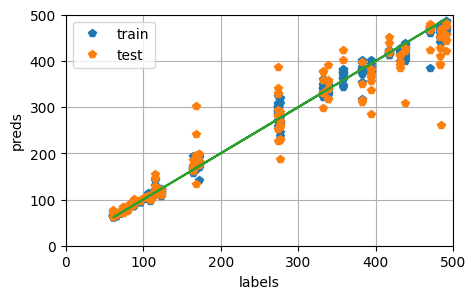

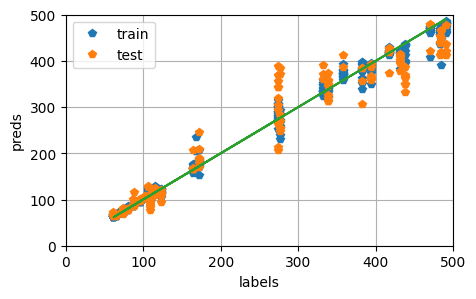

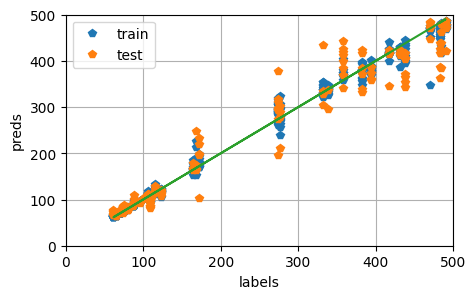

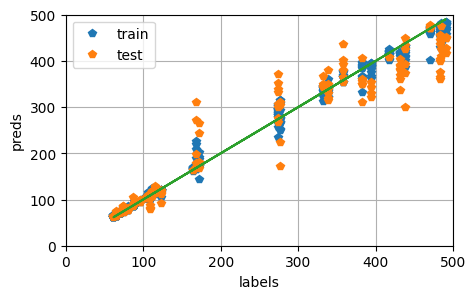

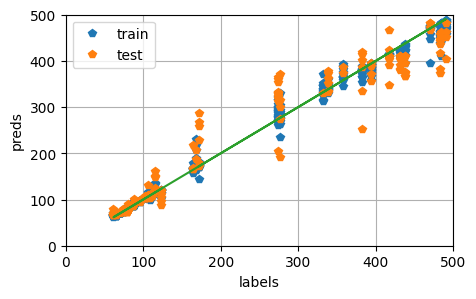

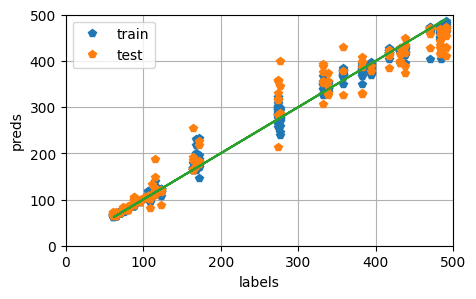

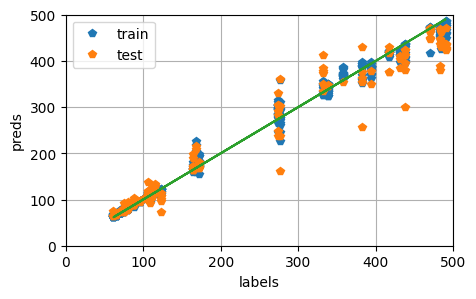

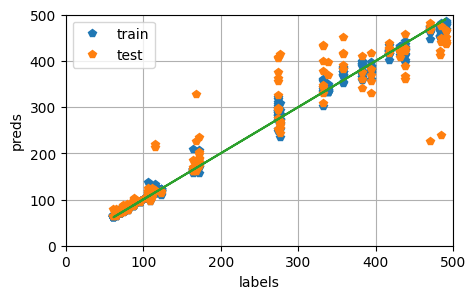

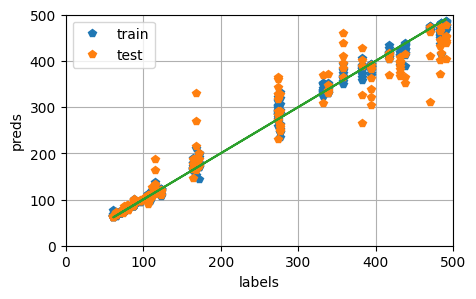

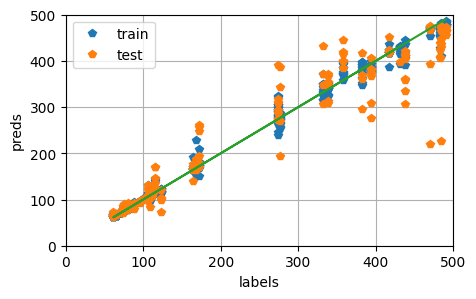

In [20]:
'''
Experiment 4:

Train on random split of union of QPS values

This model does very well since it's training on all QPS values (70% of the data)
and testing on the rest (30%)

This suggests another experiment: train on 200k, 600k and test on 400k (experiment 5)
'''

#for model in LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor():
for model in [RandomForestRegressor()]:
    score_list, model, feat_col_names = run_exp(model,
                                                pd.concat([df_200, df_400, df_600], axis=0),
                                                scale=True, 
                                                ratios=True, 
                                                log=False, 
                                                n_iter=10, 
                                                scorer=r2_score,
                                                plot=True) #change plot->True to see plots

    score_mean, score_std = np.mean([i[1] for i in score_list]), np.std([i[1] for i in score_list]) #no log
    print(f'model={model} {score_mean - score_std:.3f}--{score_mean:.3f}--{score_mean + score_std:.3f}\n')

train score = 0.993 test score = 0.813
train score = 0.992 test score = 0.236
train score = 0.992 test score = 0.826


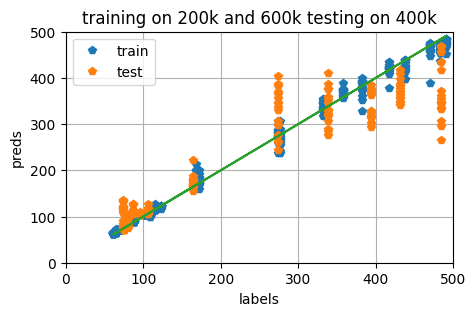

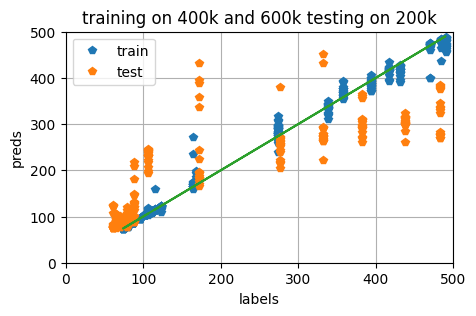

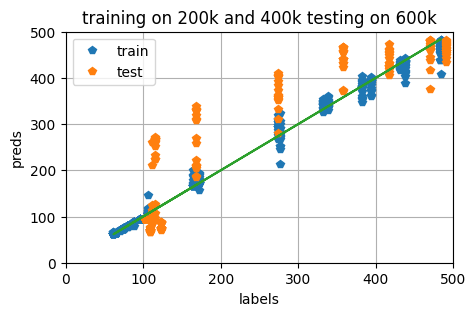

In [22]:
'''
Experiment 5:

There are three experiments - each one involves training on two
QPS values and leaving out one for testing

Training on 200k and 600k and testing on 400k works well - this is
expected since there is QPS info in the eigenvalues and we are 
not extrapolating along the QPS axis

Training on 400k/600k and testing on 200k does not generalize well -
in a sense, this is expected because we are now extrapolating along
the QPS axes. A better model might be able to do the non-linear extrapolation
(GPs, a small MLP).

Training on 200k/400k and testing on 600k does surprising well - would
expect same effect as testing on 200k since we are extrapolating.

Based on a cursory inspection of the plots below, the 200k testing has high
errors because of high itr values where latency starts saturating (because of
the SLA). Including that non-linear behavior in training helps. Needs more
rigorous analysis.
'''

scale = True
ratios = True
log = False

scorer = r2_score

model = RandomForestRegressor()

model, train_score, test_score = train(model,
                                       lat_col,
                                       pd.concat([df_200, df_600], axis=0),
                                       df_400, #test = Union(400k, 600k)
                                       scale=True, 
                                       ratios=True, 
                                       log=False, 
                                       scorer=r2_score,
                                       plot=True)      
print(f'train score = {train_score:.3f} test score = {test_score:.3f}')
_ = plt.title(f'training on 200k and 600k testing on 400k')

model, train_score, test_score = train(model,
                                       lat_col,
                                       pd.concat([df_400, df_600], axis=0),
                                       df_200, #test = Union(400k, 600k)
                                       scale=True, 
                                       ratios=True, 
                                       log=False, 
                                       scorer=r2_score,
                                       plot=True)      
print(f'train score = {train_score:.3f} test score = {test_score:.3f}')
_ = plt.title(f'training on 400k and 600k testing on 200k')

model, train_score, test_score = train(model,
                                       lat_col,
                                       pd.concat([df_200, df_400], axis=0),
                                       df_600, #test = Union(400k, 600k)
                                       scale=True, 
                                       ratios=True, 
                                       log=False, 
                                       scorer=r2_score,
                                       plot=True)      
print(f'train score = {train_score:.3f} test score = {test_score:.3f}')
_ = plt.title(f'training on 200k and 400k testing on 600k')